# OOD Detection by CAE, whiten & density approach

This notebook demonstrates the process of detecting OOD images by using compressed images from CAE (see `train_autoencoder.ipynb` for details), apply statistical whitening on the features to separate ID and OOD features, and apply a density estimator on the whitened features. The estimated density are then compared to a pre-computed threshold for OOD detection.   

Whitening process was inspired by work in  ["**Whitening Sentence Representations for Better Semantics and Faster Retrieval**"](https://arxiv.org/abs/2103.15316) by Su et.al.




## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Navigate to `ood-detection` repository

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Replace <OOD_DETECTION_REPOSITORY> with the correct location
os.chdir('/content/drive/<OOD_DETECTION_REPOSITORY>')
!git pull

## Build all datasets

Below we perform an 80/20 train/test split on the images in `ood-detection/data/bollworms-train/ID`. To train this model on a different dataset, simply change the directory inside the call to `find_image_files` below.

In [3]:
from data_utils.datasets import find_image_files, build_dataset

# Select dataset of interest
dataset = 'bollworms' # ['bollworms', 'bollworms-clean']

# These keyword arguments will be shared by all image datasets
ds_kwargs = {'cache': True, 'image_shape': (256, 256, 3), 'batch_size': 32, 'shuffle_buffer': 512}

# Build training sets of ID and OOD images
train_id_df = find_image_files(f'data/{dataset}-train/ID')
train_id_ds = build_dataset(train_id_df, augment=False, shuffle=False, **ds_kwargs)
train_ood_df = find_image_files(f'data/{dataset}-train/OOD')
train_ood_ds = build_dataset(train_ood_df, augment=False, shuffle=False, **ds_kwargs)

# Build testing sets of ID and OOD images
test_id_df = find_image_files(f'data/{dataset}-test/ID')
test_id_ds = build_dataset(test_id_df, augment=False, shuffle=False, **ds_kwargs)
test_ood_df = find_image_files(f'data/{dataset}-test/OOD')
test_ood_ds = build_dataset(test_ood_df, augment=False, shuffle=False, **ds_kwargs)

Found 7779 image files in folder "data/bollworms-train/ID"
Found 975 image files in folder "data/bollworms-train/OOD"
Found 865 image files in folder "data/bollworms-test/ID"
Found 108 image files in folder "data/bollworms-test/OOD"


## Load pre-trained autoencoder model

In [4]:
from models.autoencoder import Autoencoder

# Select model that is appropriate for the dataset
autoencoder = Autoencoder.load_model(name='20221130-Benchmark-IDEC') # bollworms
# autoencoder = Autoencoder.load_model(name='20221202-Benchmark-ID') # bollworms-clean

## Compute latent features at each layers of the autoencoder

In [ ]:
#Train
train_ds_dict = {'Train ID': train_id_ds, 'Train OOD': train_ood_ds}

train_latent_dicts = dict()
for layer in range(1, autoencoder.encode_blocks):
    train_latent_dicts[layer] = {label: autoencoder.get_latent_codes_at_layer(ds, layer) for label, ds in train_ds_dict.items()}

#Test
test_ds_dict = {'Test ID': test_id_ds, 'Test OOD': test_ood_ds}  

test_latent_dicts = dict()
for layer in range(1, autoencoder.encode_blocks):
    test_latent_dicts[layer] = {label: autoencoder.get_latent_codes_at_layer(ds, layer) for label, ds in test_ds_dict.items()}

# #save 
# np.save(f'{autoencoder.folder}/train_latent_dicts.npy', train_latent_dicts, allow_pickle=True)
# np.save(f'{autoencoder.folder}/test_latent_dicts.npy', test_latent_dicts, allow_pickle=True)

# #load
# np.load(f'{autoencoder.folder}/train_latent_dicts.npy', allow_pickle=True)
# np.load(f'{autoencoder.folder}/test_latent_dicts.npy', allow_pickle=True)


## Compute density on whitened features for all datasets

The `whiten_density` class allows for calculaton of whitened density across layers, by switching parameter `layer`. We recommend calculation only over layers 3-7, where the number of features has been compressed suitably for the density calculation. 

A number of other parameters can be changed: 
1. `whiten`: 'yes' - whitening applied. 'no' - no whitening applied. We recommend whitening. 
2. `p_features`: To reduce over-parameterisation, we allowed a parameter to adjust the proportion of test data features used to derive bias and kernel. We recommend setting low values at the earlier layers (i.e. layer 3, 4). 
3. `density_estimator`: {'BGM', 'GMM'} 
4. `bgm_gmm_covariance`: {‘full’, ‘tied’, ‘diag’, ‘spherical’} - The covariance of each mixture component
5. `bgm_gmm_n_components`: The number of mixture components.

In [7]:
from models.whiten_density import whiten_density

#assumptions
layer = 4
whiten='yes' #yes: whiten, #no: no whitening 
p_white=1 #proportion of test data used to whiten
p_features = 0.03 #proportion of test data features used to derive bias and kernel 
density_estimator = 'BGM' #BGM: Bayesian Gaussian mixture, GMM: Gaussian Mixture  
bgm_gmm_covariance = 'tied' #{‘full’, ‘tied’, ‘diag’, ‘spherical’}
bgm_gmm_n_components = 8

#get density  
density_model = whiten_density(layer = layer, 
                        whiten=whiten, 
                        p_white=p_white, 
                        p_features = p_features, 
                        density_estimator = density_estimator, 
                        bgm_gmm_covariance = bgm_gmm_covariance, 
                        bgm_gmm_n_components = bgm_gmm_n_components, 
                        train_latent_dicts = train_latent_dicts,
                        test_latent_dicts = test_latent_dicts,
                        random_seed = 297)
loglikelihood_train_ID,  loglikelihood_train_OOD, loglikelihood_test_ID, loglikelihood_test_OOD  = density_model.density_est()

## Visualize train density distribution with chosen hyperparameters 

Parameters:
layer: 4, whiten: yes, p_white: 1, density_estimator: BGM, covariance: tied, no. of components: 8 


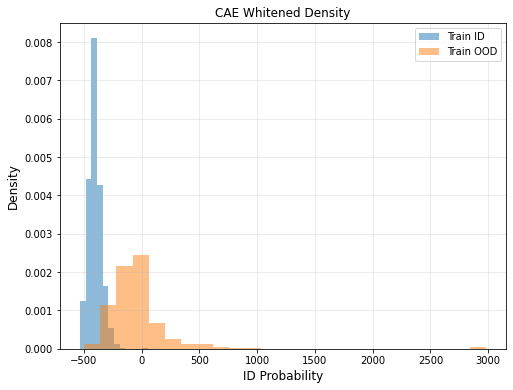

In [8]:
print('Parameters:')
print(f'layer: {layer}, whiten: {whiten}, p_white: {p_white}, density_estimator: {density_estimator}, covariance: {bgm_gmm_covariance}, no. of components: {bgm_gmm_n_components} ')
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(loglikelihood_train_ID, bins=25, alpha=0.5, density=True, label='Train ID')
ax.hist(loglikelihood_train_OOD, bins=25, alpha=0.5, density=True, label='Train OOD')
ax.set_xlabel('ID Probability', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'CAE Whitened Density')
ax.legend()
ax.grid(alpha=0.3)

## Find optimal threshold using train set

Our goal is the use weighted logistic regression to find the best threshold. We use weighted logistic regression to compute class probabilities rather than using the whitened density scores directly because there is strong class imbalance in our train and test sets (train set is approximately 90% ID and 10% OOD). Here we fit a weighted logistic regression model to the whitened density scores in the train set, and compute the threshold that maximizes the macro-averaged F1 score. We will then use the threshold that gives us the highest macro-averaged F1 score overall for our final analysis on the test set.

In [11]:
from analysis.classifiers import get_auroc, get_f1_maximizing_threshold, get_classification_report
from sklearn.linear_model import LogisticRegression

# Fit weighted logistic regression model to the training data
logit_model = LogisticRegression(penalty='none', class_weight='balanced')
x_train = np.concatenate([loglikelihood_train_ID, loglikelihood_train_OOD]).reshape(-1, 1)
y_train = np.concatenate([np.ones_like(loglikelihood_train_ID), np.zeros_like(loglikelihood_train_OOD)])
logit_model.fit(x_train, y_train)

# Compute model-predicted ID probabilities, which we treat as our new anomaly 
# detection scores. Then use these scores to find the threshold that maximizes 
# macro-averaged F1.
scores_train_id = logit_model.predict_proba(x_train[y_train == 1])[:, 1]
scores_train_ood = logit_model.predict_proba(x_train[y_train == 0])[:, 1]
threshold, max_f1_score = get_f1_maximizing_threshold(scores_train_id, scores_train_ood)

print(f'max F1 score on train set = {max_f1_score:.3f}, ID probability threshold = {threshold:.3f}')

max F1 score on train set = 0.944, ID probability threshold = 0.145


## Use optimal threshold to evaluate on test set

Now that we have chosen our optimal threshold using the train set, we can finally evaluate our OOD detection performance on the test set. The output of this code cell was used to produce the primary table of results in our main report.

In [12]:
# Compute model-predicted ID probabilities on the test set using our best model.
x_test = np.concatenate([loglikelihood_test_ID, loglikelihood_test_OOD]).reshape(-1, 1)
y_test = np.concatenate([np.ones_like(loglikelihood_test_ID), np.zeros_like(loglikelihood_test_OOD)])
scores_test_id = logit_model.predict_proba(x_test[y_test == 1])[:, 1]
scores_test_ood = logit_model.predict_proba(x_test[y_test == 0])[:, 1]

# Compute and report all classifier metrics of interest 
auc = get_auroc(scores_test_id, scores_test_ood)
class_report, conf_matrix = get_classification_report(scores_test_id, scores_test_ood, threshold)
per_class_accuracy = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
tn, fp, fn, tp = conf_matrix.ravel()

print(f'Classification report on test set [layer: {layer}, Score: Whitened Density]:')
print('')
print(class_report)
print(f'OOD accuracy: {per_class_accuracy[0]:.3f}')
print(f' ID accuracy: {per_class_accuracy[1]:.3f}')
print('')
print('Breakdown:', {'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp})
print('')
print(f'AUC: {auc:.3f}')
print('')

Classification report on test set [layer: 4, Score: Whitened Density]:

              precision    recall  f1-score   support

      OOD: 0      0.817     0.704     0.756       108
       ID: 1      0.964     0.980     0.972       865

    accuracy                          0.950       973
   macro avg      0.890     0.842     0.864       973
weighted avg      0.947     0.950     0.948       973

OOD accuracy: 0.704
 ID accuracy: 0.980

Breakdown: {'TN': 76, 'FP': 32, 'FN': 17, 'TP': 848}

AUC: 0.973



## Visualize test set performance

Parameters:
layer: 4, whiten: yes, p_white: 1, density_estimator: BGM, covariance: tied, no. of components: 8 


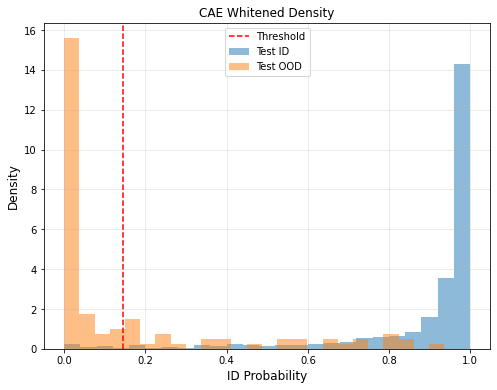

In [13]:
# First in terms of ID probabilities from weighted logistic regression model
print('Parameters:')
print(f'layer: {layer}, whiten: {whiten}, p_white: {p_white}, density_estimator: {density_estimator}, covariance: {bgm_gmm_covariance}, no. of components: {bgm_gmm_n_components} ')
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(scores_test_id, bins=25, alpha=0.5, density=True, label='Test ID')
ax.hist(scores_test_ood, bins=25, alpha=0.5, density=True, label='Test OOD')
ax.axvline(threshold, color='r', linestyle='--', label='Threshold')
ax.set_xlabel('ID Probability', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'CAE Whitened Density')
ax.legend()
ax.grid(alpha=0.3)

Parameters:
layer: 4, whiten: yes, p_white: 1, density_estimator: BGM, covariance: tied, no. of components: 8 


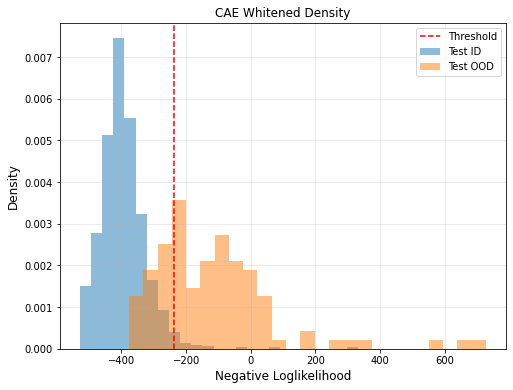

In [14]:
# Then on the original scale in terms of loglikelihood values
print('Parameters:')
print(f'layer: {layer}, whiten: {whiten}, p_white: {p_white}, density_estimator: {density_estimator}, covariance: {bgm_gmm_covariance}, no. of components: {bgm_gmm_n_components} ')
logit = lambda p: np.log(p/(1-p))
threshold_loglikelihood = ((logit(threshold) - logit_model.intercept_)/logit_model.coef_[0][0])[0]
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(loglikelihood_test_ID, bins=25, alpha=0.5, density=True, label='Test ID')
ax.hist(loglikelihood_test_OOD, bins=25, alpha=0.5, density=True, label='Test OOD')
ax.axvline(threshold_loglikelihood, color='r', linestyle='--', label='Threshold')
ax.set_xlabel('Negative Loglikelihood', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'CAE Whitened Density')
ax.legend()
ax.grid(alpha=0.3)

fig.savefig('ood_detection_cae_whitened_density.png', bbox_inches='tight', dpi=300)

# Evaluate on external OOD datasets


If present in the `ood-detection/data` folder, we can also evaluate our classifier on the `stanford_dogs` and `flowers102` datasets.

In [15]:
from data_utils.datasets import find_image_files, build_dataset

# Randomly sample this many images from each external OOD dataset below
num_images = 3000

# These keyword arguments will be shared by all image datasets
ds_kwargs = {'cache': True, 'image_shape': (256, 256, 3), 'batch_size': 32, 'shuffle_buffer': 512}

# Build stanford dogs dataset
stanford_dogs_df = find_image_files('data/stanford_dogs/Images/*')
stanford_dogs_df = stanford_dogs_df.sample(frac=1, random_state=297).iloc[:num_images]
stanford_dogs_ds = build_dataset(stanford_dogs_df, augment=False, shuffle=False, **ds_kwargs)

# Build flowers102 dataset
flowers102_df = find_image_files('data/flowers102/jpg')
flowers102_df = flowers102_df.sample(frac=1, random_state=297).iloc[:num_images]
flowers102_ds = build_dataset(flowers102_df, augment=False, shuffle=False, **ds_kwargs)

# Combine them into one external dataset dictionary object
external_ds_dict = {'Dogs': stanford_dogs_ds, 'Flowers': flowers102_ds}


Found 20580 image files in folder "data/stanford_dogs/Images/*"
Found 1620 image files in folder "data/flowers102/jpg"


## Compute latent features at each layers of the autoencoder

In [19]:
# Select dataset of interest
external_dataset = 'Dogs' # ['Dogs', 'Flowers']
external_ds = external_ds_dict[external_dataset]

#Test
test_ds_dict = {'Test ID': external_ds, 'Test OOD': external_ds}  

test_latent_dicts = dict()
for layer in range(1, autoencoder.encode_blocks):
    test_latent_dicts[layer] = {label: autoencoder.get_latent_codes_at_layer(ds, layer) for label, ds in test_ds_dict.items()}

## Compute density on whitened features for external datasets

In [21]:
from models.whiten_density import whiten_density

#assumptions
layer = 4
whiten='yes' #yes: whiten, #no: no whitening 
p_white=1 #proportion of test data used to whiten
p_features = 0.03 #proportion of test data features used to derive bias and kernel 
density_estimator = 'BGM' #BGM: Bayesian Gaussian mixture, GMM: Gaussian Mixture  
bgm_gmm_covariance = 'tied' #{‘full’, ‘tied’, ‘diag’, ‘spherical’}
bgm_gmm_n_components = 8

#get density  
density_model = whiten_density(layer = layer, 
                        whiten=whiten, 
                        p_white=p_white, 
                        p_features = p_features, 
                        density_estimator = density_estimator, 
                        bgm_gmm_covariance = bgm_gmm_covariance, 
                        bgm_gmm_n_components = bgm_gmm_n_components, 
                        train_latent_dicts = train_latent_dicts,
                        test_latent_dicts = test_latent_dicts,
                        random_seed = 297)
loglikelihood_train_ID,  loglikelihood_train_OOD, loglikelihood_test_ID, loglikelihood_test_OOD  = density_model.density_est()

## Accuracy for external datasets

In [24]:
# Compute model-predicted ID probabilities on the test set using our best model.
x_test = np.concatenate([loglikelihood_test_OOD]).reshape(-1, 1)
y_test = np.concatenate([np.zeros_like(loglikelihood_test_OOD)])

#Compute accuracy 
scores_test_ood = logit_model.predict_proba(x_test[y_test == 0])[:, 1]
external_ood_accuracy = 1.0 - np.mean(scores_test_ood > threshold)
print(f'{external_dataset} dataset (OOD) accuracy: {external_ood_accuracy:.3f}')

Dogs dataset (OOD) accuracy: 0.845
